Project 1: Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

To create a low risk portfolio, we first gather data on 100 stocks -- 10 stocks each across 10 industry sectors. Ultimately we will select one stock out of each sector, so that the volatility of the resulting portfolio is small. We will consider a portfolio where each stock has equal weight, along with one where the weights are optimized to further reduce the volatility. The underlying fact we are using in building our initial portfolio is that the smaller the correlation between random variables, the smaller the variance of a resulting portfolio (holding the variances of the individual random variables fixed).

We gather data on the performance of each stock from June 10 2019 to June 10 2024. We then test our portfolio(s) later on the past year (so as not to test the performance of the portfolio in the time range we used to create it):

In [ ]:
#yfinance issues, followed https://github.com/ranaroussi/yfinance/issues/2422#issuecomment-2840774505 to avoid

import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from curl_cffi import requests
import time

# Create session that impersonates Chrome --  doing this due to yfinance issues, followed https://github.com/ranaroussi/yfinance/issues/2422#issuecomment-2840774505 to avoid
session = requests.Session(impersonate="chrome")

# 10 industry sectors from GICS list and 10 tickers in each sector
industries = {
    "tech": ["AAPL", "MSFT", "GOOGL", "META", "ORCL", "ADBE", "NVDA", "CRM", "INTC", "AMD"],
    "healthcare": ["JNJ", "PFE", "MRK", "ABBV", "TMO", "UNH", "BMY", "AMGN", "LLY", "GILD"],
    "financial": ["JPM", "BAC", "WFC", "C", "GS", "MS", "AXP", "BK", "USB", "PNC"],
    "energy": ["XOM", "CVX", "COP", "PSX", "EOG", "VLO", "MPC", "SLB", "BKR", "HAL"],
    "consumer discretionary": ["TSLA", "AMZN", "HD", "MCD", "NKE", "LOW", "SBUX", "TJX", "GM", "F"],
    "industrial": ["HON", "GE", "UPS", "BA", "CAT", "MMM", "DE", "LMT", "UNP", "CSX"],
    "consumer staples": ["PG", "KO", "PEP", "WMT", "COST", "MO", "MDLZ", "CL", "KMB", "KR"],
    "utilities": ["NEE", "DUK", "SO", "AEP", "EXC", "D", "SRE", "PEG", "WEC", "ED"],
    "materials": ["LIN", "APD", "SHW", "ECL", "NEM", "FCX", "DD", "PPG", "VMC", "MLM"],
    "real estate": ["PLD", "AMT", "CCI", "EQIX", "PSA", "DLR", "SPG", "O", "VTR", "AVB"]
}


# flatten all tickers into one list
tickers = [ticker for industry in industries.values() for ticker in industry]
adj_close_data = {}

for ticker in tickers:
    try:
        print(f"Fetching: {ticker}")
        t = yf.Ticker(ticker, session=session)
        end = datetime(2024, 6, 10)  # 1 year ago
        start = datetime(2019, 6, 10) # 6 years ago
        # fetch data in that range
        hist = t.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), interval="1d")["Close"]
        if not hist.empty:
            adj_close_data[ticker] = hist
        else:
            print(f"Empty or missing data for {ticker}")
    except Exception as e:
        print(f"Failed to fetch {ticker}: {e}")
    time.sleep(0.05)  # small delay to avoid rate limits, just in case

# create dataframe and drop NaN/invalid entries
data = pd.DataFrame(adj_close_data)
data = data.dropna(axis=1, how='all')
data = data.ffill().bfill()
data = data.dropna()
data = data[data > 0]

# get log returns
log_returns = np.log(data / data.shift(1)).dropna()

We look at a heatmap of the covariance matrix of the log returns:

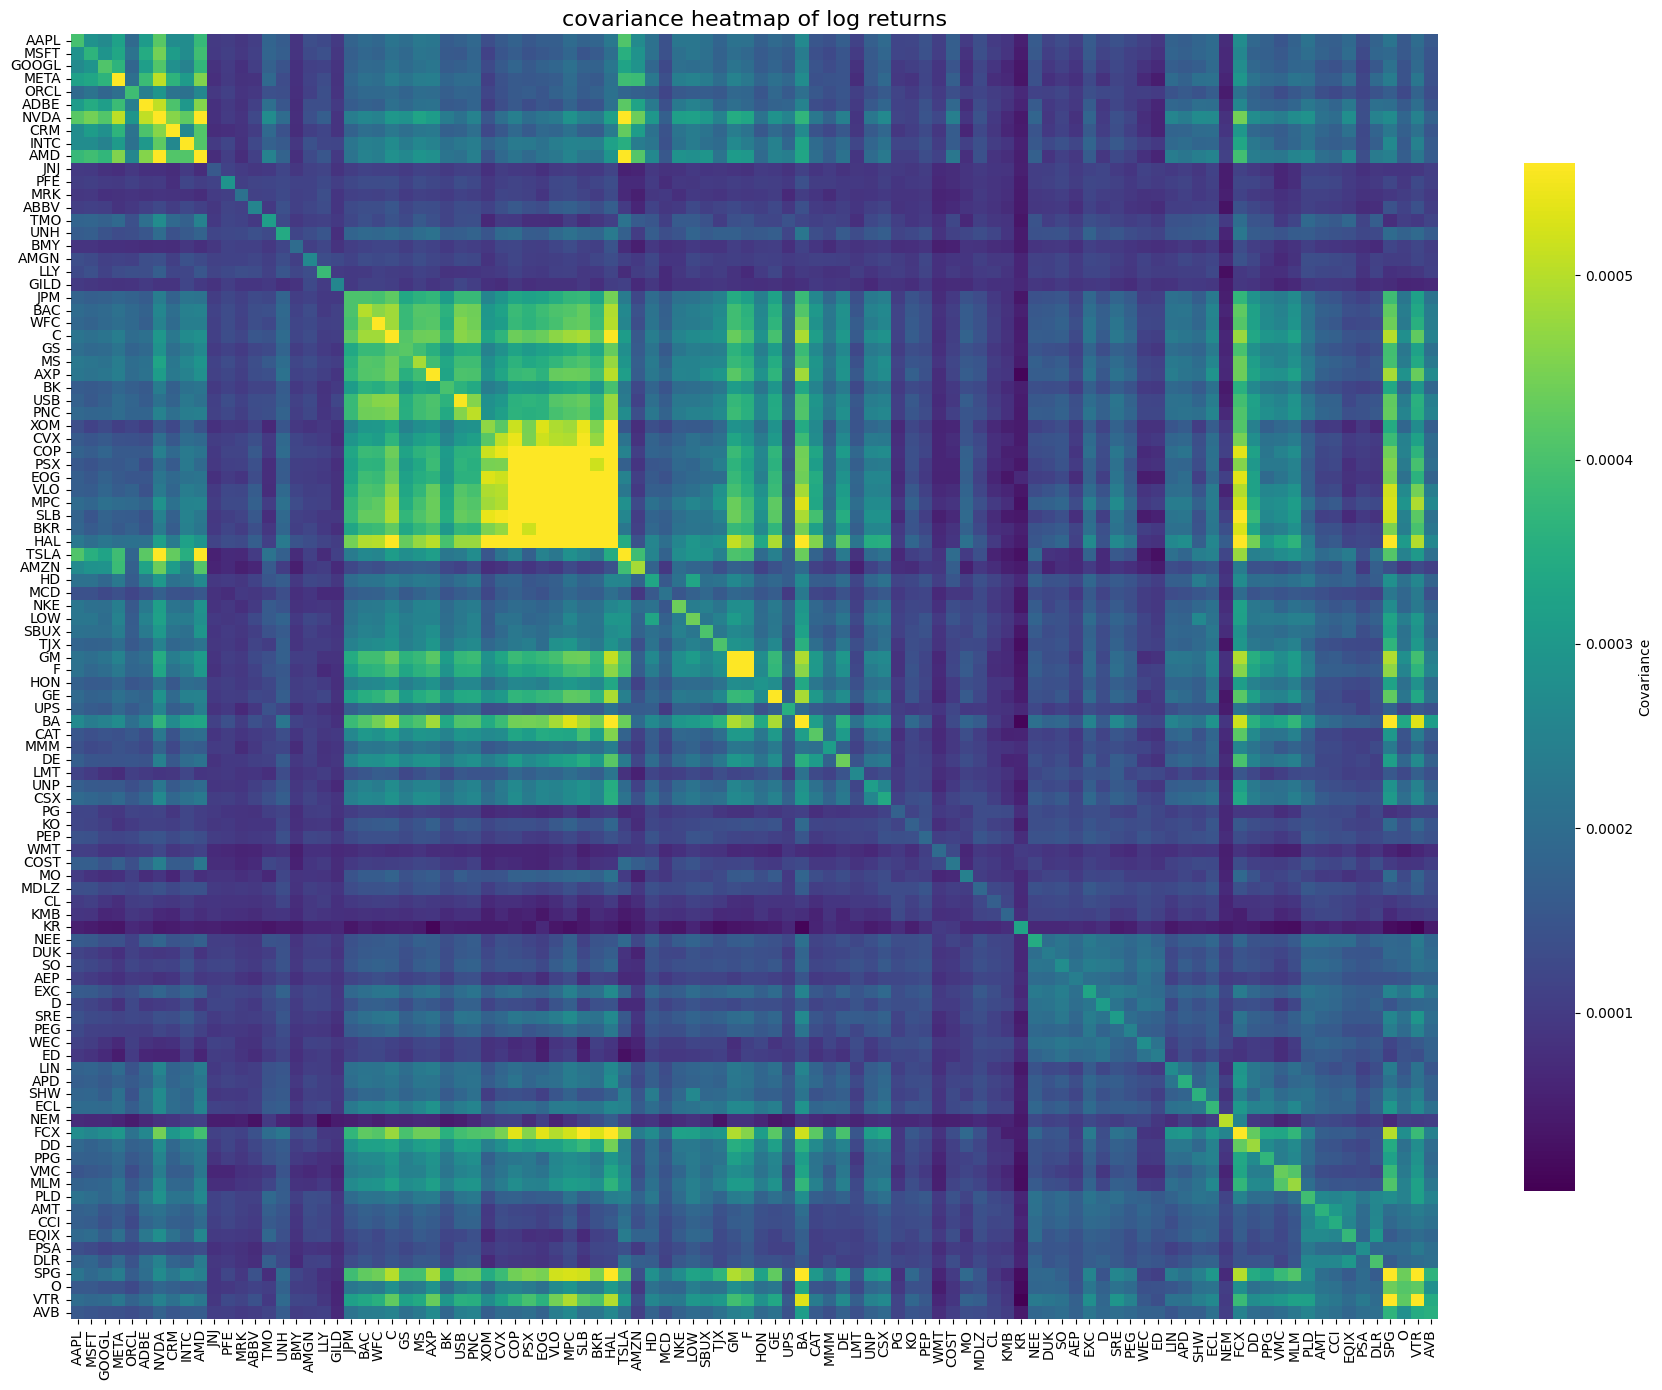

In [4]:
# compute the covariance matrix
cov_matrix = log_returns.cov()

# heatmap for the covariance matrix
plt.figure(figsize=(18, 14))
sns.heatmap(
    cov_matrix,
    cmap="viridis",
    xticklabels=True,
    yticklabels=True,
    cbar_kws={"shrink": 0.8, "label": "Covariance"},
    vmin=np.percentile(cov_matrix.values, 0.01),
    vmax=np.percentile(cov_matrix.values, 99)
)
plt.title("covariance heatmap of log returns", fontsize=16)
plt.tight_layout()
plt.show()

Let's also list the volatilities of each stock in this time period:

In [ ]:
# compute volatility (standard deviation of log returns)
volatility = log_returns.std()

# group tickers by sector and sort within each group
vol_by_sector = {}

for sector, sector_tickers in industries.items():
    valid_tickers = [ticker for ticker in sector_tickers if ticker in volatility]
    sector_vols = volatility[valid_tickers].sort_values(ascending=False)
    vol_by_sector[sector] = sector_vols

for sector, series in vol_by_sector.items():
    print(f"\n -- {sector} (sorted by volatility):")
    print(series.to_string())


 -- tech (sorted by volatility):
AMD      0.032846
NVDA     0.032716
META     0.028329
INTC     0.025095
CRM      0.024767
ADBE     0.023840
GOOGL    0.020175
AAPL     0.019913
ORCL     0.019703
MSFT     0.019100

 -- healthcare (sorted by volatility):
LLY     0.019541
UNH     0.018509
TMO     0.017700
PFE     0.017098
AMGN    0.016247
GILD    0.016113
ABBV    0.016067
MRK     0.014527
BMY     0.014103
JNJ     0.012533

 -- financial (sorted by volatility):
C      0.024433
WFC    0.024048
AXP    0.023685
USB    0.023574
PNC    0.022480
BAC    0.022354
MS     0.022036
GS     0.020382
JPM    0.020059
BK     0.019942

 -- energy (sorted by volatility):
HAL    0.036317
SLB    0.031516
EOG    0.030552
VLO    0.030212
MPC    0.030148
BKR    0.028252
COP    0.028156
PSX    0.026665
CVX    0.022489
XOM    0.021616

 -- consumer discretionary (sorted by volatility):
TSLA    0.040888
F       0.027171
GM      0.026599
AMZN    0.022041
LOW     0.020921
NKE     0.020872
TJX     0.020082
SBUX    0.

We now find the selection of 10 stocks, 1 from each sector, that minimizes the maximum covariance among them, after filtering out high-volatility stocks:

In [6]:
from itertools import product

# filter each sector to low-volatility tickers
low_volatility_tickers = volatility[volatility <= 0.022].index

sector_candidates = {
    sector: [ticker for ticker in tickers if ticker in low_volatility_tickers]
    for sector, tickers in industries.items()
}

# create all combinations
sector_names = list(sector_candidates.keys())
combinations = list(product(*[sector_candidates[s] for s in sector_names]))

# find the combination minimizing max covariance
def max_cov(tickers):
    cov = log_returns[list(tickers)].cov().values
    np.fill_diagonal(cov, -np.inf)
    return np.max(cov)

best_combo = None
min_max_cov = np.inf

for combo in combinations:
    curr_max = max_cov(combo)
    if curr_max < min_max_cov:
        min_max_cov = curr_max
        best_combo = combo

best_combo_named = dict(zip(sector_names, best_combo))
print("Best 10-tuple (one per sector) with min-max covariance:")
print(best_combo_named)
print(f"Minimum of maximum pairwise covariance: {min_max_cov:.6f}")

Best 10-tuple (one per sector) with min-max covariance:
{'tech': 'AAPL', 'healthcare': 'JNJ', 'financial': 'BK', 'energy': 'XOM', 'consumer discretionary': 'HD', 'industrial': 'HON', 'consumer staples': 'PG', 'utilities': 'NEE', 'materials': 'LIN', 'real estate': 'PLD'}
Minimum of maximum pairwise covariance: 0.000237


The selected tickers are [AAPL, JNJ, BK, XOM, HD, HON, PG, NEE, LIN, PLD]. We build a uniformly weighted portfolio with these and look at the portfolio's performance over the last year:

Let's look at its log and ordinary returns over the last year:

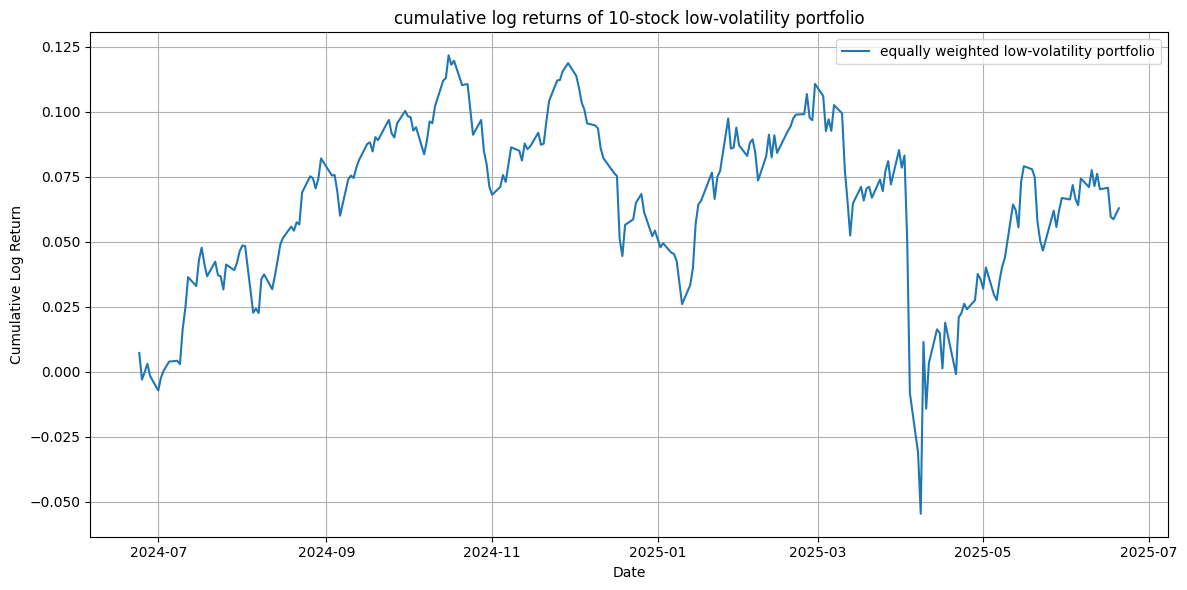

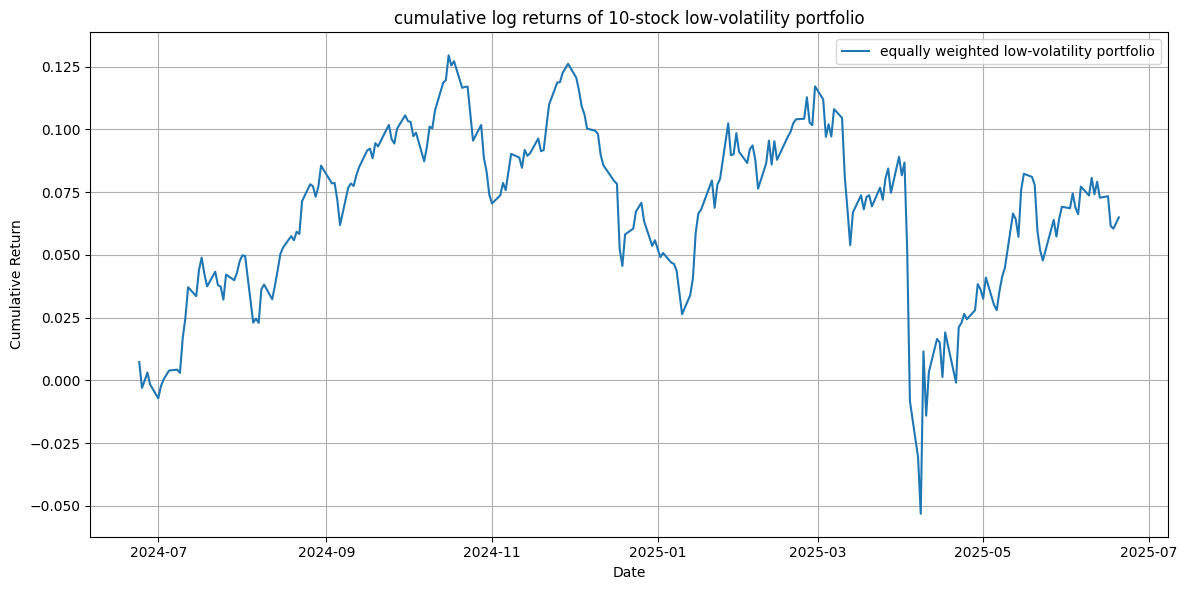

In [12]:
# the chosen 10-tuple of tickers
selected_tickers = ["AAPL", "JNJ", "BK", "XOM", "HD", "HON", "PG", "NEE", "LIN", "PLD"]

# download individual stock data
price_data = pd.DataFrame()

for ticker in selected_tickers:
    t = yf.Ticker(ticker, session=session)
    hist = t.history(period="1y", interval="1d")["Close"]
    price_data[ticker] = hist

# clean the data
price_data = price_data.ffill().bfill().dropna()
price_data = price_data[price_data > 0]

# get log returns
log_returns = np.log(price_data / price_data.shift(1)).dropna()

# set uniform weights
weights = np.full(len(selected_tickers), 1 / len(selected_tickers))

# portfolio log returns
portfolio_log_returns = log_returns.dot(weights)

# cumulative log return
cumulative_log_returns = portfolio_log_returns.cumsum()





# now plot the log returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_log_returns, label="equally weighted low-volatility portfolio")
plt.title("cumulative log returns of 10-stock low-volatility portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# convert to ordinary returns and cumulative ordinary return
portfolio_returns = np.exp(portfolio_log_returns) - 1
portfolio_value = (1 + portfolio_returns).cumprod() * initial_value

# compute cumulative ordinary returns
cumulative_returns = (1 + portfolio_returns).cumprod() - 1

# plot
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label="equally weighted low-volatility portfolio")
plt.title("cumulative log returns of 10-stock low-volatility portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


We compute the volatility:

In [8]:
daily_volatility = portfolio_log_returns.std()
annualized_volatility = daily_volatility * np.sqrt(252)

print(f"Daily Volatility: {daily_volatility:.4%}")
print(f"Annualized Volatility: {annualized_volatility:.4%}")

Daily Volatility: 1.0051%
Annualized Volatility: 15.9559%


The nearly 16% annualized volatility calls into question the "low volatility" label we are using, but given the dramatic market movement around Liberation Day, and the events surrounding it, this seems fairly low. 

Now, by contrast, the first highly volatile stock that one thinks of is TSLA. We plot its performance against the above portfolio:

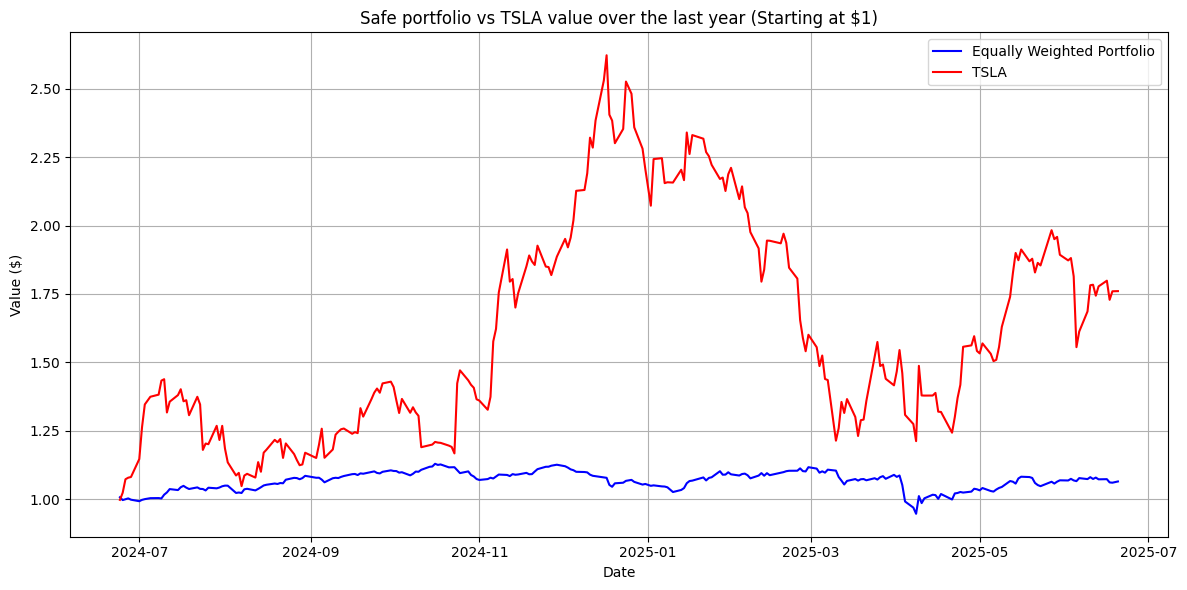

In [ ]:
# Download TSLA data

initial_value = 1

tsla_ticker = yf.Ticker("TSLA", session=session)
tsla_hist = tsla_ticker.history(period="1y", interval="1d")["Close"]
tsla_hist = tsla_hist.ffill().bfill().dropna()
tsla_hist = tsla_hist[tsla_hist > 0]

tsla_log_returns = np.log(tsla_hist / tsla_hist.shift(1)).dropna()
tsla_returns = np.exp(tsla_log_returns) - 1
tsla_value = (1 + tsla_returns).cumprod() * initial_value

# Align TSLA and portfolio on the same dates
common_dates = portfolio_value.index.intersection(tsla_value.index)
portfolio_value_aligned = portfolio_value.loc[common_dates]
tsla_value_aligned = tsla_value.loc[common_dates]

# Plot both
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_aligned, label="Equally Weighted Portfolio", color="blue")
plt.plot(tsla_value_aligned, label="TSLA", color="red")
plt.title("Safe portfolio vs TSLA value over the last year (Starting at $1)")
plt.xlabel("Date")
plt.ylabel("Value in USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

TSLA's volatility:

In [14]:
daily_volatility_TSLA = tsla_log_returns.std()
annualized_volatility_TSLA = daily_volatility_TSLA * np.sqrt(252)

print(f"Daily Volatility: {daily_volatility_TSLA:.4%}")
print(f"Annualized Volatility: {annualized_volatility_TSLA:.4%}")

Daily Volatility: 4.6299%
Annualized Volatility: 73.4975%


Let's see how these two portfolios performed over the past six years:

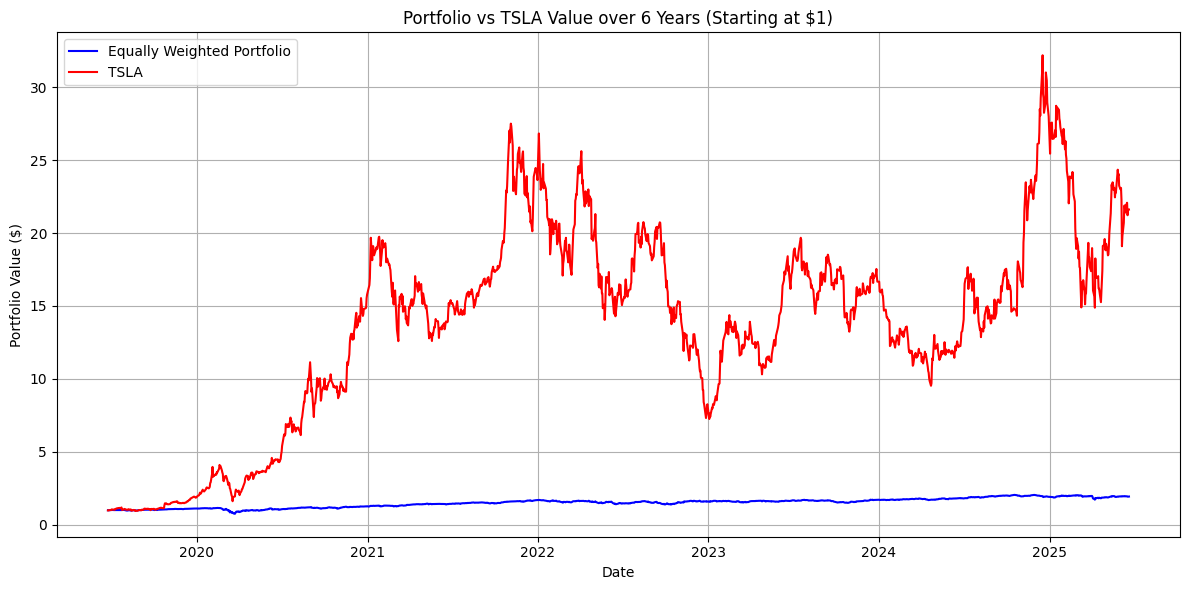

In [ ]:
end_date = datetime.today()
start_date = end_date - timedelta(days=6 * 365)
price_data_6y = pd.DataFrame()

# download 6-year daily data for each ticker
for ticker in selected_tickers:
    t = yf.Ticker(ticker, session=session)
    hist = t.history(
        start=start_date.strftime("%Y-%m-%d"),
        end=end_date.strftime("%Y-%m-%d"),
        interval="1d"
    )["Close"]
    price_data_6y[ticker] = hist

# Clean data
price_data_6y = price_data_6y.ffill().bfill().dropna()
price_data_6y = price_data_6y[price_data_6y > 0]

# Log returns and portfolio construction
log_returns_6y = np.log(price_data_6y / price_data_6y.shift(1)).dropna()
weights_6y = np.full(len(selected_tickers), 1 / len(selected_tickers))
portfolio_log_returns_6y = log_returns_6y.dot(weights_6y)
portfolio_returns_6y = np.exp(portfolio_log_returns_6y) - 1

initial_value = 1
portfolio_value_6y = (1 + portfolio_returns_6y).cumprod() * initial_value

# TSLA over same 6-year period
tsla = yf.Ticker("TSLA", session=session)
tsla_hist_6y = tsla.history(
    start=start_date.strftime("%Y-%m-%d"),
    end=end_date.strftime("%Y-%m-%d"),
    interval="1d"
)["Close"]

tsla_hist_6y = tsla_hist_6y.ffill().bfill().dropna()
tsla_hist_6y = tsla_hist_6y[tsla_hist_6y > 0]
tsla_log_returns_6y = np.log(tsla_hist_6y / tsla_hist_6y.shift(1)).dropna()
tsla_returns_6y = np.exp(tsla_log_returns_6y) - 1
tsla_value_6y = (1 + tsla_returns_6y).cumprod() * initial_value

# align dates
common_dates_6y = portfolio_value_6y.index.intersection(tsla_value_6y.index)
portfolio_value_6y = portfolio_value_6y.loc[common_dates_6y]
tsla_value_6y = tsla_value_6y.loc[common_dates_6y]

plt.figure(figsize=(12, 6))
plt.plot(portfolio_value_6y, label="Equally Weighted Portfolio", color="blue")
plt.plot(tsla_value_6y, label="TSLA", color="red")
plt.title("Portfolio vs TSLA Value over 6 Years (Starting at $1)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value in USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Now, for our "safe" portfolio, we will optimize the weights as in class, to make its volatility even smaller. We again use 2019-2024 data to do so:

In [ ]:
from scipy.optimize import minimize

price_data = pd.DataFrame()
for ticker in selected_tickers:
    t = yf.Ticker(ticker, session=session)
    end = datetime(2024, 6, 10) # 1 year ago
    start = datetime(2019, 6, 10) # 6 years ago
    hist = t.history(start=start.strftime("%Y-%m-%d"), end=end.strftime("%Y-%m-%d"), interval="1d")["Close"]
    price_data[ticker] = hist

# clean data
price_data.dropna(inplace=True)

# calculate log daily returns
daily_returns = np.log(price_data / price_data.shift(1)).dropna()

# covariance matrix of returns, annualized
covariance_matrix = 252 * daily_returns.cov()

initial_weights = np.array([1 / 10] * 10)

# constraints
constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
    {'type': 'ineq', 'fun': lambda w: np.min(w) - 0.10},
    {'type': 'ineq', 'fun': lambda w: 0.35 - np.max(w)},
)

# as in class, objective function: minimize portfolio volatility
def portfolio_volatility(weights):
    return np.sqrt(np.dot(weights.T, np.dot(covariance_matrix.values, weights)))

# now optimize
result = minimize(portfolio_volatility, initial_weights, constraints=constraints, bounds=[(0.05, 0.3)] * 10)

optimal_weights = result.x
print("\nOptimal asset weights to minimize volatility:")
for ticker, weight in zip(selected_tickers, optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")

print(f"\nThe optimal portfolio volatility subject to the constraints is {result.fun:.4f}")

weights = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])
uniform_result = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix.values, weights)))

print(f"\nPortfolio volatility with uniform weights is {uniform_result}")



Optimal asset weights to minimize volatility:
AAPL: Weight = 0.0500
JNJ: Weight = 0.3000
BK: Weight = 0.0500
XOM: Weight = 0.0548
HD: Weight = 0.0500
HON: Weight = 0.0500
PG: Weight = 0.2952
NEE: Weight = 0.0500
LIN: Weight = 0.0500
PLD: Weight = 0.0500

The optimal portfolio volatility subject to the constraints is 0.1803

Portfolio volatility with uniform weights is 0.20417203338476728


The optimization successfully gives us a noticeably smaller volatility. Note that this is volatility on the 2019-2024 range, which is the range on which we are building our portfolio. Now we see how this new rebalanced portfolio performs on the past year.

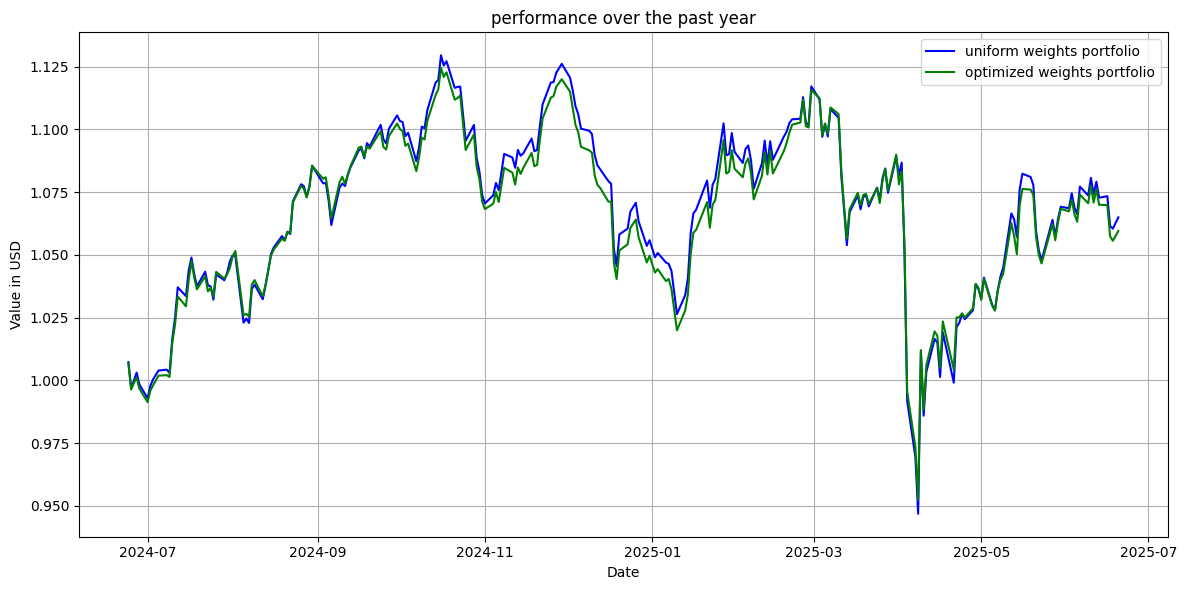

In [18]:
initial_value = 1.0

weights = np.array([0.09000302, 0.15111077, 0.09005269, 0.09001429, 0.0900033,  0.09000302, 0.1286761,  0.09006317, 0.09007058, 0.09000306])
portfolio2_log_returns = log_returns.dot(weights)
portfolio2_returns = np.exp(portfolio2_log_returns) - 1
portfolio2_value = (1 + portfolio2_returns).cumprod() * initial_value


# align all three just in case
common_dates = portfolio_value.index.intersection(tsla_value.index).intersection(portfolio2_value.index)
portfolio_value = portfolio_value.loc[common_dates]
portfolio2_value = portfolio2_value.loc[common_dates]
tsla_value = tsla_value.loc[common_dates]

# plot only the safe portfolios to see what's going on (TSLA would mess up the scale)
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value, label="uniform weights portfolio", color="blue")
plt.plot(portfolio2_value, label="optimized weights portfolio", color="green")
#plt.plot(tsla_value, label="TSLA", color="red")
plt.title("performance over the past year")
plt.xlabel("Date")
plt.ylabel("Value in USD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Overall the portfolios seem to be quite similar in performance.

Now let's compare everything to a risk-free portfolio:

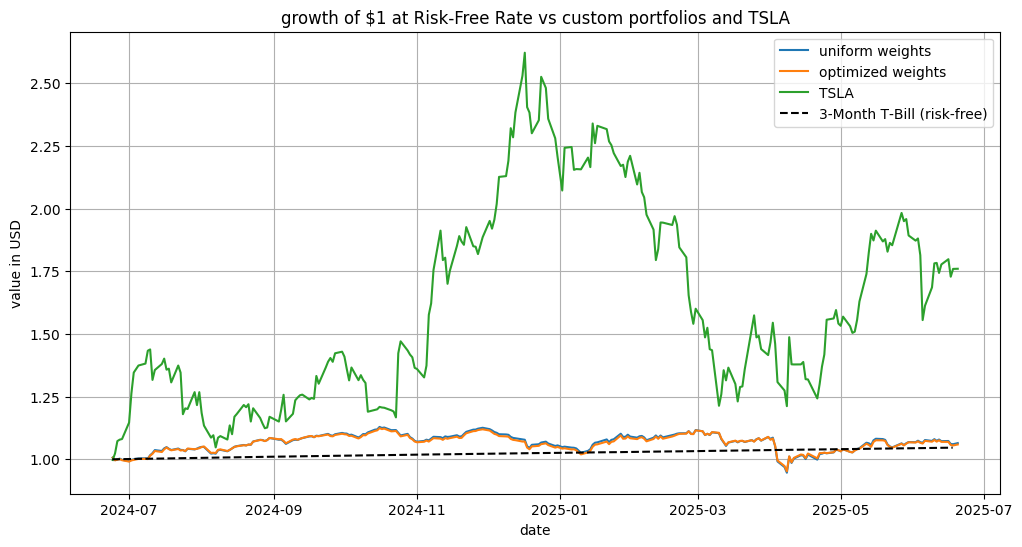

In [23]:
# risk free rate $1 growing

from pandas_datareader import data as pdr

end = datetime.today()
start = end - timedelta(days=365)

# get 3-month treasury rates (percent per annum)
risk_free = pdr.DataReader('DGS3MO', 'fred', start, end).dropna()

# Convert to daily decimals
risk_free['rf_daily'] = risk_free['DGS3MO'] / 100 / 252

# calculate cumulative growth of $1
risk_free['rf_value'] = (1 + risk_free['rf_daily']).cumprod()

plt.figure(figsize=(12,6))
plt.plot(portfolio_value, label="uniform weights")
plt.plot(portfolio2_value, label="optimized weights")
plt.plot(tsla_value, label = "TSLA")
plt.plot(risk_free['rf_value'], label="3‑Month T‑Bill (risk-free)", linestyle='--', color='black')
plt.title("growth of $1 at Risk-Free Rate vs custom portfolios and TSLA")
plt.xlabel("date")
plt.ylabel("value in USD")
plt.legend()
plt.grid(True)
plt.show()
